[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marharyta-aleksandrova/conformal-learning/blob/main/theory/conformal_learning_from_scratch.ipynb?authuser=1)

# Conformal learning from scratch

Conformal learning is a framework that allows constructing predictions with predefined accuracy guarantees for *iid* data. It can be used on top of any traditional predictive algorithm for both classification and regression. The theory behind conformal learning might seem complicated, but it is based on a simple idea.

The goal of this notebook is to guide you through the theory of conformal classifiers.

We will build a conformal classifier step-by-step explaining the required background on the way. In the end, we will confirm that the constructed model gives the same results as the code from [`nonconformist`](https://github.com/donlnz/nonconformist) library.

We will be working with the Inductive Conformal Prediction (ICP) framework. But similar reasoning applies to Transductive Conformal Prediction as well.
The idea behind conformal regression is the same as for conformal classification. 

# Setting up

Importing required libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

import matplotlib.pyplot as plt

Uncomment/Comment the code below to set dark/white background for plots.

In [2]:
plt.style.use('dark_background')

# Datasets

For demonstration, we will use a synthetic dataset with 4 classes and 2000 points in each class. Points of a class are normally distributed around the corresponding class center on a 2D plane.

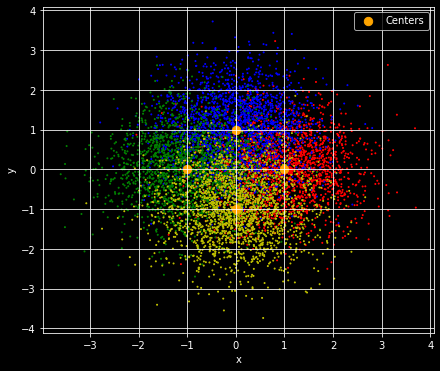

In [3]:
np.random.seed(20)
# centers of 4 classes
centers = [
    [ 1,  0],
    [ 0,  1],
    [-1,  0],
    [ 0, -1],
]

# colors to plot members of different classes
color_arr = ['r', 'b', 'g', 'y']

# number of instances per class
n_points = 2000
# these arrays will store information about datapoints
data_x = []
data_y = []
data_class = []
data_color = []

# standard deviation to generate the class instances
sigma = 0.8
# data generation
for class_val in range(0, len(centers)):
    x, y = centers[class_val]
    data_class.extend([class_val for j in range(0, n_points)])
    data_color.extend([color_arr[class_val] for j in range(0, n_points)])
    data_x.extend(np.random.normal(x, sigma, size=n_points))
    data_y.extend(np.random.normal(y, sigma, size=n_points))
# putting everything into a dataframe
data_df = pd.DataFrame({
    'x': data_x,
    'y': data_y,
    'class': data_class,
    'color': data_color,
})
# plotting the dataset
data_df.plot(
    kind='scatter',
    x='x',
    y='y',
    c=data_df['color'],
    s=1,
    grid=True,
    figsize=(7,6),
)

# showing the centers in orange
plt.scatter(np.array(centers).T[0], np.array(centers).T[1], s=70, c='orange', label='Centers')
plt.legend()
plt.show()

# Traditional (Point) predictor

We will start with motivation of conformal prediction. Let us first construct the traditional (point) classifier using [SVM](https://en.wikipedia.org/wiki/Support-vector_machine) algorithm.

First, we split the dataset into training (90\%) and test (10\%) sets.

In [4]:
# fraction of the dataset to be used for testing
test_frac = 0.1

np.random.seed(2)
# performing random permutation of the dataset
idx = np.random.permutation(len(data_df))
# constucting training and test datasets
test_size = int(len(data_df) * 0.1)
train_size = len(data_df) - test_size
idx_train = idx[:train_size]
idx_test = idx[train_size:]

print('Size of training set: {}'.format(len(idx_train)))
print('Size of test set: {}'.format(len(idx_test)))

Size of training set: 7200
Size of test set: 800


Now, we are ready to bild an SVM model and test its accuracy.

In [5]:
model = SVC(probability=True)
model.fit(data_df[['x', 'y']].values[idx_train, :], data_df['class'].values[idx_train])
prediction = model.predict(data_df[['x', 'y']].values[idx_test, :])
acc = sum(prediction[:] == data_df['class'].values[idx_test][:]) / len(idx_test)
print('Accuracy of prediction: {}%'.format(acc * 100))

Accuracy of prediction: 65.375%


We achieved an accuracy of approximately $65\%$. 

Analyzing the distribution of the data points (shown below for a reference), we can conclude that probably no other classification algorithm will improve this result considerably. Indeed, many data points overlap in our 2D space, and there is not enough information to distinguish between them.

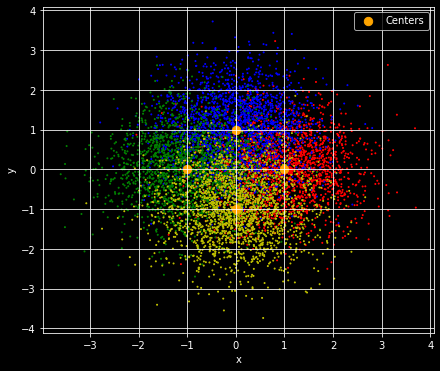

In [6]:
data_df.plot(kind='scatter', x='x', y='y', c=data_df['color'], s=1, grid=True, figsize=(7,6),)
# showing the centers in orange
plt.scatter(np.array(centers).T[0], np.array(centers).T[1], s=70, c='orange', label='Centers')
plt.legend()
plt.show()

However, imagine that we need higher accuracy in our particular application. And we are ready to sacrifice the **precision** of our predictions to achieve the required accuracy. For example, we are ready to accept the prediction <$a$ belongs to class 1 or class 3 with probability $0.95$>  instead of <$a$ belongs to class 3 with probability $0.65$>. 

> By **precision** we mean here the number of class labels predicted per a data point. Traditional (point) predictor predicts only one class label, it is as precise as possible. Here, we are ready to sacrifice this precision. We are ready to allow 0, 1, or more class labels per data point to guarantee the required accuracy. As a result, we'll be producing *region* predictions.

Below are some examples of possible relative applications:
1. medicine
2. insurance
3. banking
4. ...

In short, any critical application producing human-related predictions can be a potential candidate.

So, is there a way to achieve, for example, $95\%$ accuracy?

## Can we achieve accuracy of $95\%$?

One possible way of achieving the required accuracy can be based on the analysis of probabilities produced by the underlying classification model.

In [7]:
prediction_proba = model.predict_proba(data_df[['x', 'y']].values[idx_test, :])
print('Probabilities of 4 possible class labels generated by our SVM classifier \n\
for the first 5 datapoints in the test set:\n')
print('   class_1     class_2    class_3    class_4')
for i in range(0, 5):
    print('{}: {}'.format(i + 1, prediction_proba[i]))

Probabilities of 4 possible class labels generated by our SVM classifier 
for the first 5 datapoints in the test set:

   class_1     class_2    class_3    class_4
1: [0.55172226 0.06165259 0.04880244 0.33782271]
2: [0.02265381 0.05512115 0.73301176 0.18921329]
3: [0.03171894 0.09159033 0.75444521 0.12224553]
4: [0.05374289 0.75803387 0.16381808 0.02440515]
5: [0.08666454 0.04873815 0.29555432 0.56904299]


The standard point predictors output the class label associated with the highest probability value. The results would look like this (*True* indicates which class label is predicted):

In [8]:
prediction_point = np.zeros_like(prediction_proba)
prediction_point[np.arange(len(prediction_proba)), prediction_proba.argmax(1)] = 1
np.array(prediction_point, dtype=bool)
for i in range(0, 5):
    print('{}: {}'.format(i + 1, np.array(prediction_point[i], dtype=bool)))

1: [ True False False False]
2: [False False  True False]
3: [False False  True False]
4: [False  True False False]
5: [False False False  True]


If we need to achieve $95\%$ accuracy, we can output all class labels with associated probability $\geq 1 - 0.95 = 0.05$. In this way, all discarded class labels should not produce more than $5\%$ of errors. We will refer to this value as the *allowed error rate*, *significance*, or $\epsilon$.

In [9]:
significance = 0.05

In [10]:
prediction_region_naive = prediction_proba > significance
for i in range(0, 5):
    print('{}: {}'.format(i + 1, prediction_region_naive[i]))

1: [ True  True False  True]
2: [False  True  True  True]
3: [False  True  True  True]
4: [ True  True  True False]
5: [ True False  True  True]


As expected, now more than 1 class label is predicted, we got a region prediction.

Let us now evaluate how good the constructed region prediction is.
1. First, we want to confirm that we achieved the desired accuracy of $95\%$.
2. Second, it would be interesting to evaluate how far we are now from the *precise* point predictor. In particular, we can calculate the values of the following efficiency metrics:
    1. $oneC$ - fraction of singleton predictions. In the case of the point predictor, all predictions are singletons. Naturally, we would want this value to be close to 1; that is, we prefer larger values.
    2. $avgC$ - the average size of the prediction set. For a point predictor, we have $avgC=1$. For the region predictor constructed above, many data points have more than 1 predicted label. So, smaller values of $avgC$ are preferable.

Functions for evaluation of range classifiers:

In [11]:
# Accuracy for a region prediction:
# A region prediction produces an error if the resulting prediction set does not
# contain the true value 
def get_accuracy(prediction, real_class):
    correct = 0
    N = len(prediction)
    for i in range(0, N):
        if prediction[i][real_class[i]]:
            correct += 1
    return correct / N

# calculating metrics: oneC & avgC
def get_oneC_avgC(prediction):
    arr = np.array(prediction)
    oneC = 0
    avgC = 0
    for i in range(0, len(arr)):
        # number of predicted lables
        num_predicted = arr[i].sum()
        avgC += num_predicted
        # is it a singleton?
        if num_predicted == 1:
            oneC += 1
        pass
    oneC /= len(arr)
    avgC /= len(arr)
    return oneC, avgC

Let us now evaluate the efficiency of the region prediction constructed above:

In [12]:
acc = get_accuracy(prediction_region_naive, data_df['class'].values[idx_test])
oneC, avgC = get_oneC_avgC(prediction_region_naive)
print('Accuracy of the region predictor: {}%'.format(acc * 100))
print('Efficiency:\n\t oneC = {}\n\t avgC = {}'.format(oneC, avgC))

Accuracy of the region predictor: 96.625%
Efficiency:
	 oneC = 0.0
	 avgC = 2.95


We achieved an even better value of accuracy than required: $96.6\%$. The resulting region prediction has no singletons and on average $2.95$ class labels are predicted per data point.

However, we set $95\%$ as the required accuracy threshold.
This discrepancy is related to the calibration properties of different classifiers, check [here](https://scikit-learn.org/stable/modules/calibration.html) for more information.

Maybe, by excluding some of the predicted labels we could improve the efficiency of our region prediction. That is, we might achieve better values of $oneC$ and $avgC$. This is exactly what the conformal prediction framework can help us with.

# Conformal classifier from scratch

Let us split the dataset into 3 parts: training, test, and calibration. 

The training and the test sets will be used in the same way as before: to train the predictive model and to evaluate its efficiency. We will use the calibration part to estimate when a particular label should be included in the final region prediction.

As before, the test dataset will contain $10\%$ of the available data. The rest will be split into training, $80\%$, and calibration, $20\%$.

In [13]:
# fraction of the dataset to be used for testing
test_frac = 0.1
# fraction of the remaining dataset to be used for calibration
calib_frac = 0.2

np.random.seed(2)
# random permulation
idx = np.random.permutation(len(data_df))
# constucting test, training and calibration datasets
test_size = int(len(data_df) * test_frac) 
calib_size = int(len(data_df) * (1 - test_frac) * calib_frac)
train_size = len(data_df) - test_size - calib_size
idx_train, idx_cal, idx_test = idx[:train_size], idx[train_size:train_size + calib_size], idx[train_size + calib_size:]

print('Test size: {}'.format(test_size))
print('Calibration size: {}'.format(calib_size))
print('Train size: {}'.format(train_size))

Test size: 800
Calibration size: 1440
Train size: 5760


Let us fit the tradition point predictor on the training set

In [14]:
model.fit(data_df[['x', 'y']].values[idx_train, :], data_df['class'].values[idx_train])

SVC(probability=True)

## Intuition: measuring conformity of predictions on the calibration dataset

Let us analyze the predictions on the calibration set. Let us see which *probability values* are a*ssociated with the true class labels* and how they are *distributed*. That is, we will analyze how *conformal* every data point from the calibration set is (*conformity function*).

In [15]:
# generating predictions for the calibration dataset
predictions_cal = model.predict_proba(X=data_df[['x', 'y']].values[idx_cal, :])
# extracting the predicted probability for the correct class labesl
calib_conformal_vals = []
for i in range(0, len(idx_cal)):
    # correct class label
    cl = data_df['class'].values[idx_cal][i]
    # associated probability
    calib_conformal_vals.append(predictions_cal[i][cl])

In [16]:
calib_conformal_vals[:5]

[0.46178348070234915,
 0.4811247633424626,
 0.15201782011747808,
 0.20882860016272425,
 0.7666005843086938]

Let us now sort the obtained values and plot the resulting empirical distribution of the *conformity values*:

Text(0.5, 1.0, 'Distribution of conformity values')

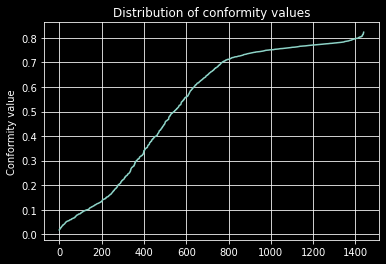

In [18]:
calib_conformal_vals = np.sort(calib_conformal_vals)
plt.plot(calib_conformal_vals)
plt.grid(True)
plt.ylabel('Conformity value')
plt.title('Distribution of conformity values')

Now let us analyze where the predicted probability values for the test dataset are situated in this distribution, and what is the associated empirical error rate of not including the relevant class label into the region prediction.

We will start with generating predictions for the test set:

In [19]:
predictions_test = model.predict_proba(X=data_df[['x', 'y']].values[idx_test, :])

We will do the analysis for the first datapoint in the test set. Here are the generated probabilities associated with 4 possible class labels:

In [20]:
predictions_test[0]

array([0.58120731, 0.05633852, 0.04733344, 0.31512073])

### Should we include class 1?

In [21]:
print('Distribution of probabilities for the first datapoint in the test set:')
predictions_test[0]

Distribution of probabilities for the first datapoint in the test set:


array([0.58120731, 0.05633852, 0.04733344, 0.31512073])

Let us analyze the position of probability associated with class 0 in our empirical distribution of conformity values:

Text(0.5, 1.0, 'Distribution of conformity values')

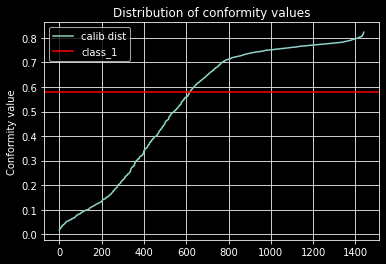

In [22]:
plt.plot(calib_conformal_vals)
plt.axhline(y=predictions_test[0][0], color='r', linestyle='-')
plt.legend(['calib dist', 'class_1'])
plt.grid(True)
plt.ylabel('Conformity value')
plt.title('Distribution of conformity values')

If we include the newly calculated value into the empirical distribution, then the following fraction of points are situated on the left-hand side (including the newly added one):

In [23]:
val = sum(calib_conformal_vals <= predictions_test[0][0]) + 1
print('Number of points on the left hand side (<=): {}'.format(val))
print('Fraction of points on the left hand side:    {}%'.format(np.round(val / (len(calib_conformal_vals) + 1) * 100, 2)))

Number of points on the left hand side (<=): 620
Fraction of points on the left hand side:    43.03%


And the following fraction of the points are situated on the right-hand side:

In [24]:
val = (sum(calib_conformal_vals > predictions_test[0][0]) + 1) 
print('Number of points on the right hand side (>): {}'.format(val))
print('Fraction of points on the right hand side:   {}%'.format(np.round(val / (len(calib_conformal_vals) + 1) * 100, 2)))

Number of points on the right hand side (>): 822
Fraction of points on the right hand side:   57.04%


Recall that this distribution was constructed for the probability values of the true class labels. This means, that more than $43\%$ of the observed probabilities of the correct classes had lower values than the analyzed one. From here, we can conclude the following. If we do not include the associated class label (1 in this case), then from the observed distribution, the probability of making a mistake through this action is $43.03\%$. 

It is higher than our allowed error rate $\epsilon = 5\%$. It means that this class label should be included.

The idea here is based on estimating probabilities from a Cumulative Distribution Function, [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function).

### Should we include class 2?

Let us perform the same analysis for class 2.

In [25]:
print('Distribution of probabilities for the first datapoint in the test set:')
predictions_test[0]

Distribution of probabilities for the first datapoint in the test set:


array([0.58120731, 0.05633852, 0.04733344, 0.31512073])

Text(0.5, 1.0, 'Distribution of conformity values')

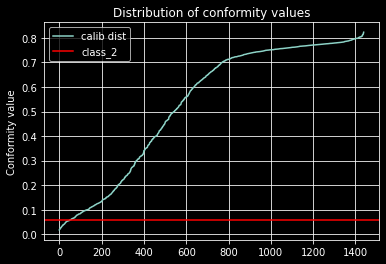

In [27]:
plt.plot(calib_conformal_vals)
plt.axhline(y=predictions_test[0][1], color='r', linestyle='-')
plt.grid(True)
plt.legend(['calib dist', 'class_2'])
plt.ylabel('Conformity value')
plt.title('Distribution of conformity values')

If we include the newly calculated value into the empirical distribution, then the following fraction of points are situated on the left hand side (including the newly added one):

In [28]:
val = sum(calib_conformal_vals <= predictions_test[0][1]) + 1
print('Number of points on the left hand side (<=): {}'.format(val))
print('Fraction of points on the left hand side:    {}%'.format(np.round(val / (len(calib_conformal_vals) + 1) * 100, 2)))

Number of points on the left hand side (<=): 48
Fraction of points on the left hand side:    3.33%


And the following fraction of the points are situated on the right hand side:

In [29]:
val = (sum(calib_conformal_vals > predictions_test[0][1]) + 1) 
print('Number of points on the right hand side (>): {}'.format(val))
print('Fraction of points on the right hand side:   {}%'.format(np.round(val / (len(calib_conformal_vals) + 1) * 100, 2)))

Number of points on the right hand side (>): 1394
Fraction of points on the right hand side:   96.74%


Using the same reasoning, we can conclude that if this class label is not included in the region prediction, the probability of making a mistake is $3.33\%$. It is less than our allowed error rate $\epsilon = 5\%$. Thereby, this class label should not be included.

### Generalizing for the whole test set

We will use the same reasoning to decide if *every class label* should be included in the final region prediction for *every data point* from our test dataset. Using the empirical distribution of conformity values calculated on the calibration dataset, we will calculate the probability of making a mistake by not including a particular class label. This value is referred to as *p-value*. If $p\_value < \epsilon$, then the relevant class label is discarded. Otherwise, it is included in the region prediction.

In [30]:
p_vals_inverse = np.zeros((len(idx_test), len(centers)))
for i in range(0, len(idx_test)):
    for j in range(0, len(centers)):
        p_vals_inverse[i,j] = (sum(calib_conformal_vals <= predictions_test[i,j]) + 1) / (len(calib_conformal_vals) + 1)

Here are the *p-values* for the first data point that we analyzed above, the values correspond to our calculations for class 1 and class2:

In [31]:
p_vals_inverse[0]

array([0.43025677, 0.0333102 , 0.02151284, 0.26509368])

And the associated region prediction:

In [32]:
p_vals_inverse[0] > significance

array([ True, False, False,  True])

As we can see, the first and the fourth classes are included in the region prediction for the first data point.

Below are the results for the whole test set:

In [33]:
prediction = p_vals_inverse > significance
prediction

array([[ True, False, False,  True],
       [False, False,  True,  True],
       [False,  True,  True,  True],
       ...,
       [ True, False,  True,  True],
       [ True,  True, False,  True],
       [ True, False,  True,  True]])

Let us now evaluate the accuracy and the efficiency of the resulting region prediction:

In [34]:
print('Conformal classification based on conformity values:')
acc = get_accuracy(prediction, data_df['class'].values[idx_test])
oneC, avgC = get_oneC_avgC(prediction)
print('Accuracy of region predictor: {}%'.format(acc * 100))
print('Efficience:\n\t oneC = {}\n\t avgC = {}'.format(oneC, avgC))

Conformal classification based on conformity values:
Accuracy of region predictor: 95.0%
Efficience:
	 oneC = 0.0
	 avgC = 2.57125


For reference, below are the relevant values for our naive region classifier.

In [35]:
acc = get_accuracy(prediction_region_naive, data_df['class'].values[idx_test])
oneC, avgC = get_oneC_avgC(prediction_region_naive)
print('Accuracy of the region predictor: {}%'.format(acc * 100))
print('Efficiency:\n\t oneC = {}\n\t avgC = {}'.format(oneC, avgC))

Accuracy of the region predictor: 96.625%
Efficiency:
	 oneC = 0.0
	 avgC = 2.95


As we can see, the newly constructed conformal classifier based on conformity values achieves exactly the required accuracy of $95\%$. Also, it improves the performance in terms of $avgC$ metric. Now, the average size of the prediction set is $2.57$ instead of $2.95$.

## From conformity values to nonconformity values (nonconformity functions)

Above, we constructed a conformal prediction based on conformity values.
However, the theory of conformal prediction is based on nonconformity functions.
Let us transition from conformity values to nonconformity values.

The conformity values chosen above show how well a data point conforms to the model of a specific class.
To estimate this value, we used the predicted probability of the fact that a data point $a$ belongs to the class $i$, $\hat{P}_i(a)$.
A good way to estimate the level of nonconformity, how much a data point $a$ is nonconformal with a class $i$, can be $1 - \hat{P}_i(a)$.

Let us calculate the nonconformity values for the calibration dataset and plot their empirical distribution.

Text(0.5, 1.0, 'Distribution of nonconformity values')

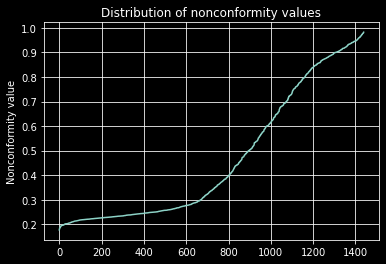

In [37]:
calib_non_conformal_vals = 1 - calib_conformal_vals
calib_non_conformal_vals = np.sort(calib_non_conformal_vals)
plt.plot(calib_non_conformal_vals)
plt.grid(True)
plt.ylabel('Nonconformity value')
plt.title('Distribution of nonconformity values')

From here, we can do the same analysis as above to estimate the probability of an error if a particular class label is not included in the region prediction. As we inverted the values, now the size of the right-hand side of the distribution is proportional to the probability of an error.

Below are the nonconformity values for the first datapoint from the test set:

In [38]:
prediction_test_non_conformal = 1 - predictions_test
prediction_test_non_conformal[0]

array([0.41879269, 0.94366148, 0.95266656, 0.68487927])

Should we include class 1?

Text(0.5, 1.0, 'Distribution of nonconformity values')

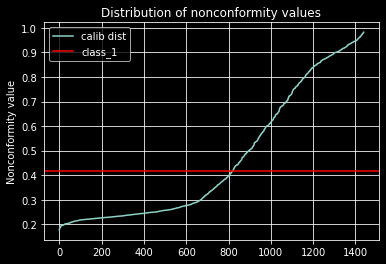

In [39]:
plt.plot(calib_non_conformal_vals)
plt.axhline(y=prediction_test_non_conformal[0][0], color='r', linestyle='-')
plt.legend(['calib dist', 'class_1'])
plt.grid(True)
plt.ylabel('Nonconformity value')
plt.title('Distribution of nonconformity values')

In [53]:
val = sum(calib_non_conformal_vals >= prediction_test_non_conformal[0][0]) + 1
print('Probability of making an error: {}%'.format(np.round(val / (len(calib_non_conformal_vals) + 1) * 100, 2)))

Probability of making an error: 43.03%


As the probability of making an error is larger than $5\%$, class 1 should be included.

Note also, that we obtain exactly the same numbers as for the distribution of conformity values, as expected.

Should we include class 2?

Text(0.5, 1.0, 'Distribution of nonconformity values')

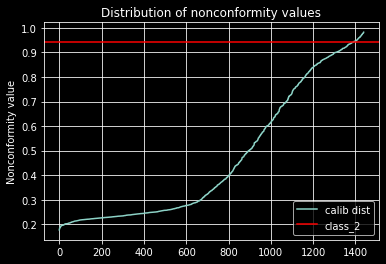

In [41]:
plt.plot(calib_non_conformal_vals)
plt.axhline(y=prediction_test_non_conformal[0][1], color='r', linestyle='-')
plt.legend(['calib dist', 'class_2'])
plt.grid(True)
plt.ylabel('Nonconformity value')
plt.title('Distribution of nonconformity values')

In [54]:
val = sum(calib_non_conformal_vals >= prediction_test_non_conformal[0][1]) + 1
print('Probability of making an error: {}%'.format(np.round(val / (len(calib_non_conformal_vals) + 1) * 100, 2)))

Probability of making an error: 3.33%


The estimated value is lower than $5\%$, so we do not need to include this class label.

Finally, we can generalize for the whole test dataset: if $p\_value < \epsilon$, then the relevant class label is discarded. Otherwise, it is included in the region prediction.

In [43]:
p_vals = np.zeros((len(idx_test), len(centers)))
for i in range(0, len(idx_test)):
    for j in range(0, len(centers)):
        p_vals[i,j] = (sum(calib_non_conformal_vals >= prediction_test_non_conformal[i,j]) + 1) / (len(calib_non_conformal_vals) + 1)

Now, we can obtain the final region predictions for the whole test set:

In [44]:
prediction_non_conf = p_vals > significance
prediction_non_conf

array([[ True, False, False,  True],
       [False, False,  True,  True],
       [False,  True,  True,  True],
       ...,
       [ True, False,  True,  True],
       [ True,  True, False,  True],
       [ True, False,  True,  True]])

Let us confirm that the resulting region prediction is the same as the one we obtained with conformity values:

In [45]:
print('Number of different predictions for predictors based on \nconformity and nonconformity values:')
np.sum(prediction_non_conf != prediction)

Number of different predictions for predictors based on 
conformity and nonconformity values:


0

As expected, we get exactly the same predictions.

# Where does the nonconformity function come from?

A *nonconformity* function is any function used to measure the nonconformity or strangeness of a data point with respect to a class. In the section above, we used *inverse probability* or *hinge* nonconformity function which is calculated as 1 minus the probability of the true class:

$$
\Delta \left[ h (\vec{x_i}), y_i \right] = 1 - \hat{P}_h(y_i | \vec{x_i}),
$$
where 
$\vec{x_i}$ is the analyzed data point, $y_i$ is a tentative class label, and
$\hat{P}_h(y_i | \vec{x_i})$ is the probability assigned to this label given the 
instance $\vec{x_i}$ by the underlying classifier $h$. 

This is not the only possible nonconformity function. Another option widely used in classification is *margin* nonconformity function defined as follows:

$$
\Delta \left[ h (\vec{x_i}), y_i\right] = \max_{y \neq y_i}\hat{P}_h(y | \vec{x_i}) - \hat{P}_h(y_i | \vec{x_i}).
$$
This function measures how different is the probability of the label $y_i$ from the probability of
another most probable class label.

In general, any function can be used as a nonconformity function. However, a suitable definition of the latter will result in more efficient conformal classifiers, see [(Shafer & Vovk, 2008)](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf) for more details. 

Different nonconformity functions will also result in different characteristics of nonconformal classifiers. For example, it was shown that *inverse probability* results in lower values of $avgC$ and *margin* results in higher values of $oneC$, see [(Johansson et al., 2017)](https://ieeexplore.ieee.org/abstract/document/7966105) and [(Aleksandrova & Chertov, 2021)](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf).

Now, let us confirm that our conformal classifier produces the same results as the one from the `nonconformist` Python library.

# Conformal learning with `nonconformist`

We will be following [this tutorial](https://github.com/donlnz/nonconformist/blob/master/README.ipynb) for `nonconformist`.

1. We use `icp = IcpClassifier(nc, smoothing=False)` with `smoothing=False` to avoid  stochastic smoothing of $p$-values, see documentation of `nonconformist`.
2. We set *inverse probability* as nonconformity function in the following line:
`nc = NcFactory.create_nc(model, err_func=InverseProbabilityErrFunc())`
3. Finally, we use the SVM model trained above to avoid deviations due to random initializations in the traning phase. For this, we pass the already trained model to the constructor `nc = NcFactory.create_nc(model, err_func=InverseProbabilityErrFunc())` and we comment the line `icp.fit(...)` that would retrain the model.

Installing `nonconformist`

In [46]:
!pip install nonconformist

  Created wheel for nonconformist: filename=nonconformist-2.1.0-py3-none-any.whl size=17840 sha256=8183ce6d69e9e47c9b2a74479d8a8e69d2b0612857eb87a471e2a971998e7caa
  Stored in directory: /root/.cache/pip/wheels/87/01/fa/9e7ef08e0d6dbdab8e37671b66f4b81e6c41423f9084249675
Successfully built nonconformist


In [47]:
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory
from nonconformist.nc import InverseProbabilityErrFunc, MarginErrFunc

nc = NcFactory.create_nc(model, err_func=InverseProbabilityErrFunc())	# Create a default nonconformity function
icp = IcpClassifier(nc, smoothing=False)			# Create an inductive conformal classifier

# We comment this line to use the same underlying classifier that was built above.
# Like this, we avoid deviations due to random initializations in the traning phase. 
# Fit the ICP using the proper training set
# icp.fit(data_df[['x', 'y']].values[idx_train, :], data_df['class'].values[idx_train])

# Calibrate the ICP using the calibration set
icp.calibrate(data_df[['x', 'y']].values[idx_cal, :], data_df['class'].values[idx_cal])

# Produce predictions for the test set, with confidence 95%
prediction_lib = icp.predict(data_df[['x', 'y']].values[idx_test, :], significance=significance)

Let us have a look at our region predictions:

In [48]:
prediction_lib

array([[ True, False, False,  True],
       [False, False,  True,  True],
       [False,  True,  True,  True],
       ...,
       [ True, False,  True,  True],
       [ True,  True, False,  True],
       [ True, False,  True,  True]])

And compare them with what we had before:

In [52]:
print('Number of different predictions between noncomformist and our region\n\
predictor based on nonconformity values:')
np.sum(prediction_non_conf != prediction_lib)

Number of different predictions between noncomformist and our region
predictor based on nonconformity values:


0

We god the same predictions. It means, we successfully constructed a conformal predictor from scratch!

# Further reading

If you want to learn more about conformal learning, below are some resources to start with:

1. [`nonconformist` libray](https://github.com/donlnz/nonconformist)
2. A nice [tutorial](https://www.youtube.com/watch?v=nql000Lu_iE) by Anastasios N. Angelopoulos and Stephen Bates
2. A [video](https://www.youtube.com/watch?v=r6bhm_A-YcQ&t=9s) with a nice explanation by Maria Navarro
3. A [tutorial](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf) on conformal prediction by Glenn Shafer and Vladimir Vovk
4. Conformal learning conference [COPA](https://cml.rhul.ac.uk/copa2021/)
5. Distribution-Free Uncertainty Quantification Workshop at ICML [DFUQ-2021](https://sites.google.com/berkeley.edu/dfuq21/home?authuser=0)6. [Awesome Conformal Prediction](https://github.com/valeman/awesome-conformal-prediction) list of resources